# Ioannou_Georgios


## Copyright © 2022 by Georgios Ioannou


___
<h1 align="center"> A/B Testing </h1>

## Prompt

> Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

> Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.


___
<h2 align="center"> Libraries </h2>


In [1]:
# Import libraries.

%matplotlib inline

import matplotlib.pyplot as plt     # Plotting/Visualization.
import numpy as np                  # Data wrangling.
import pandas as pd                 # Data handling.
import scipy.stats as stats         # Probability distributions & statistical functions.
import seaborn as sns               # Plotting/Visualization.
import statsmodels.stats.api as sms # Estimating statistical models.

from math import ceil # Rounding function.
# Test for proportions based on normal (z) test and confidence interval for a binomial proportion.
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
sns.set()


___
<h2 align="center"> Sample Size Calculation </h2>


In [2]:
# Calculate effect size based on our expected rates.

effect_size = sms.proportion_effectsize(0.06, 0.09)


In [3]:
# Calculate sample size needed.

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
    )

# Round up to next integer.

required_n = ceil(required_n)

# Print/Display/Return the sample size needed.
print('Sample size needed = ', required_n)


Sample size needed =  1199


___
<h2 align="center"> Collecting and Preparing the Data </h2>


In [4]:
# Load the tiktok_data.csv into a dataframe.

# Read the file tiktok_data.csv located inside the data folder and then load the data.

df = pd.read_csv('data/tiktok_data.csv')


# Print/Display/Return the first 5 rows of the file tiktok_data.csv to make sure the file was loaded successfully.

df.head()


,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Print the shape.

df.shape


(275781, 5)

In [6]:
# Inspect / remove nulls and duplicates.

print('NULLS')
print(df.isnull().sum(), '\n')
print('Duplicates')
print('df.duplicated().sum() =', df.duplicated().sum())


NULLS
user_id      0
timestamp    0
group        0
button       0
liked        0
dtype: int64 

Duplicates
df.duplicated().sum() = 0


In [7]:
# Get the info of the dataframe.

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [8]:
# Make sure all the control group are seeing the star button and viceversa.

pd.crosstab(df['group'], df['button'])


button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [9]:
# Check that no users have been sampled multiple times.

session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users, 'users have been sampled multiple times.')


3453 users have been sampled multiple times.


In [10]:
# If there are users who have been sampled multiple times, remove them from the dataframe.

users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]


In [11]:
# Print the shape.

df.shape


(268875, 5)

___
### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.


In [12]:
# Perform simple random sampling to split the data into control and treatment.

control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state = 22)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state = 22)


In [13]:
# Create one table called ab_test that has both the cleaned control and treatment data.

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)
ab_test


,user_id,timestamp,group,button,liked
0,644761,2017-01-20 5:19:16,control,heart,0
1,856804,2017-01-02 23:19:00,control,heart,0
2,728826,2017-01-03 4:16:37,control,heart,0
3,865441,2017-01-19 3:59:57,control,heart,0
4,796969,2017-01-05 4:08:26,control,heart,0
...,...,...,...,...,...
2393,647852,2017-01-16 4:47:04,treatment,star,0
2394,814529,2017-01-15 1:01:37,treatment,star,1
2395,924465,2017-01-13 8:37:42,treatment,star,0
2396,660778,2017-01-12 1:55:29,treatment,star,0


In [14]:
# Count the test groups to make sure that they are balanced.

ab_test['group'].value_counts()


control      1199
treatment    1199
Name: group, dtype: int64

___
<h2 align="center"> Analysis Visualization </h2>


In [15]:
# Find the like rate by group.

like_rates = ab_test.groupby('group')['liked']

# Find the standard deviation of the proportion.

std_p = lambda x: np.std(x, ddof = 0) 

# Find the standard error of the proportion (std / sqrt(n)).

se_p = lambda x: stats.sem(x, ddof = 0)

# Calculate the final like rate.

like_rates = like_rates.agg([np.mean, std_p, se_p])
like_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
like_rates.style.format('{:.3f}')


,conversion_rate,std_deviation,std_error
group,,,
control,0.109,0.312,0.009
treatment,0.118,0.323,0.009


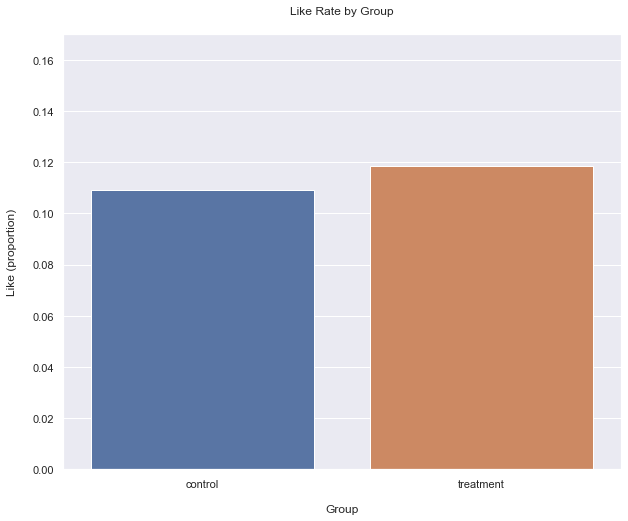

In [16]:
# Plot the like rate by group on a bar plot.

plt.figure(figsize = (10, 8))

sns.barplot(x = ab_test['group'], y = ab_test['liked'], ci = False)

plt.ylim(0, 0.17)
plt.title('Like Rate by Group', pad = 20)
plt.xlabel('Group', labelpad = 15)
plt.ylabel('Like (proportion)', labelpad = 15);


___
<h2 align="center"> Testing for Statistical Significance </h2>


In [17]:
# Get the like count for both control and treatment groups.

control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

# Get the number of samples in both groups.

n_control = control_results.count()
n_treatment = treatment_results.count()

# Sum up the number of successes (likes) in both groups.

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_control, n_treatment]


In [18]:
# Find the z statistic and p value for proportions based on normal ztest.

z_stat, p_val = proportions_ztest(successes, nobs = nobs)

# Find the confidence intervals for each test group.

(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes, nobs = nobs, alpha = 0.05)


In [19]:
# Print z statistic.

print(f'z statistic: {z_stat:.2f}')

# Print p-value.

print(f'p-value: {p_val:.3f}')


# Print ci 95% for control group.

print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')


# Print ci 95% for treatment group.

print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatment:.3f}]')



z statistic: -0.71
p-value: 0.479
ci 95% for control group: [0.092, 0.127]
ci 95% for treatment group: [0.100, 0.137]


___
<h1 align="center"> <span style="color:#FFA500"> Were the results significant? </span> </h1>

___
<h2 align="center"> <span style="color:#964B00"> Since the p-value = 0.479 which is a lot larger than the alpha value (α = 0.05) threshold, the results extremely significant. <br/><br/> The difference between the two values is (0.479 - 0.05 = 0.429). <br/><br/> The p-value is about <i> 9.5 </i> larger than the alpha value. </span> </h2>

___


___
<h1 align="center"> <span style="color:#FFA500"> What would you advise the engineering team to do moving forward? </span> </h1>

___
<h2 align="center"> <span style="color:#964B00"> Since the p-value is a lot larger than the alpha value we accept the null hypothesis H<sub>0</sub> (<i> heart </i>) and thus reject the alternative hypothesis H<sub>A</sub> (<i> star </i>). <br/><br/> The p-value is not sufficient enough to support the alternative hypothesis H<sub>A</sub>. <br/><br/> If we look at the confidence interval for the control group ([0.092, 0.127], or 9.2 - 12.7%) we notice that tt does include our target value of 9% (the 3% uplift we were aiming for).
 <br/><br/> Therefore, I would advise the engineering team to stay with the old design of the heart button. </span> </h2>

___
